# Задача

Построить прогноз количества перерабатываемых контейнеров на год вперед.

Загружаем библиотеки.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
%run f2forecast.py

Читаем файл с данными (лист 'Data').

In [3]:
df=pd.read_excel("sample_dataset.xlsx", index_col='Xm', sheet_name='Data')
df.head()

,Y
Xm,
2015-01-01,1388
2015-02-01,1088
2015-03-01,1813
2015-04-01,1523
2015-05-01,1595


In [4]:
df.tail()

,Y
Xm,
2018-12-01,1777
2019-01-01,1536
2019-02-01,1190
2019-03-01,1530
2019-04-01,1840


Исходный набор содержит данные по месяцам с января 2015 года по апрель 2019 года.

Выполним валидацию данных и выведем на экран значения.

In [5]:
df = validate_series(df)
print(df)

               Y
Xm              
2015-01-01  1388
2015-02-01  1088
2015-03-01  1813
2015-04-01  1523
2015-05-01  1595
2015-06-01  1475
2015-07-01  1657
2015-08-01  1506
2015-09-01  1208
2015-10-01  1506
2015-11-01  1544
2015-12-01  1583
2016-01-01   997
2016-02-01  1264
2016-03-01  1238
2016-04-01  1370
2016-05-01  1305
2016-06-01  1351
2016-07-01  1603
2016-08-01  1433
2016-09-01  1343
2016-10-01  1430
2016-11-01  1555
2016-12-01  1663
2017-01-01  1090
2017-02-01  1047
2017-03-01  1608
2017-04-01  1263
2017-05-01  1482
2017-06-01  1921
2017-07-01  1905
2017-08-01  1991
2017-09-01  1072
2017-10-01  2054
2017-11-01  1616
2017-12-01  1192
2018-01-01  1249
2018-02-01  1453
2018-03-01  2200
2018-04-01  2024
2018-05-01  2268
2018-06-01  1902
2018-07-01  2150
2018-08-01  2016
2018-09-01  1679
2018-10-01  1670
2018-11-01  1726
2018-12-01  1777
2019-01-01  1536
2019-02-01  1190
2019-03-01  1530
2019-04-01  1840


Построим график по месяцам на всем периоде.

[<AxesSubplot:>]

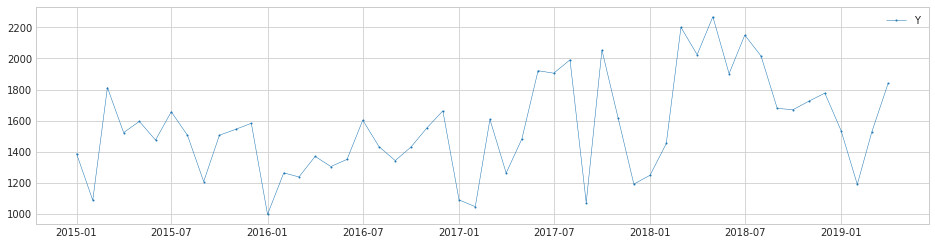

In [6]:
plot(df)

Посмотрим основные статистики ряда данных.

In [7]:
df.describe()

,Y
count,52.000000
mean,1555.557692
std,315.367847
min,997.000000
25%,1333.500000
50%,1533.000000
75%,1738.750000
max,2268.000000


Среднее значение набора не очень близко к медиане, что позволяет нам говорить о нормальном распределении значений. 

Посмотрим на точки, которые легли выше 2200 контейнеров и ниже 1000 контейнеров. Потенциально эти значения могут быть выбросами. 

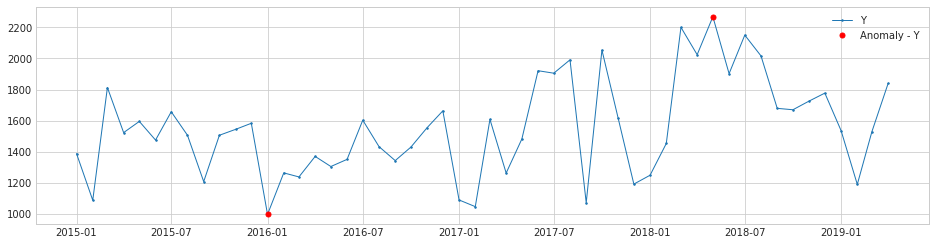

In [8]:
threshold_ad = ThresholdAD(high=2200, low=1000)
anomalies = threshold_ad.detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

In [9]:
anomalies[anomalies.Y]

,Y
Xm,
2016-01-01,True
2018-05-01,True


Аномалии пришлись на две точки. Потенциально в мае 2018 года может быть выброс. Этот период надо изучить детальнее.

Посмотрим на выбросы при помощи метода OutlierDetector и попробуем менять уровень значимости от 0.01 до 0.1.

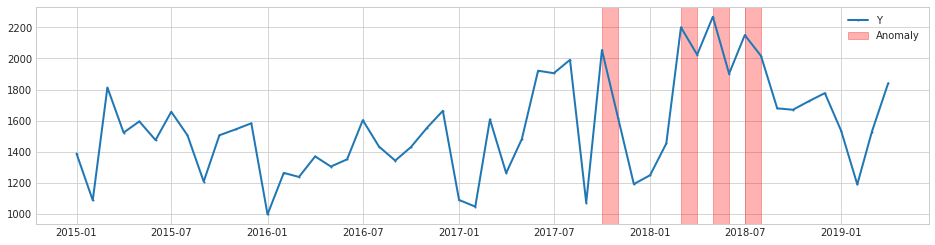

In [10]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.06))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', curve_group='all', anomaly_alpha=0.3);

In [11]:
anomalies[anomalies]

Xm
2017-10-01    True
2018-03-01    True
2018-05-01    True
2018-07-01    True
dtype: bool

Мы видим, что есть все признаки выброса в периоде первой половины 2018 года. Для окончательного заключения изучим отклонения в сезонной компоненте. 

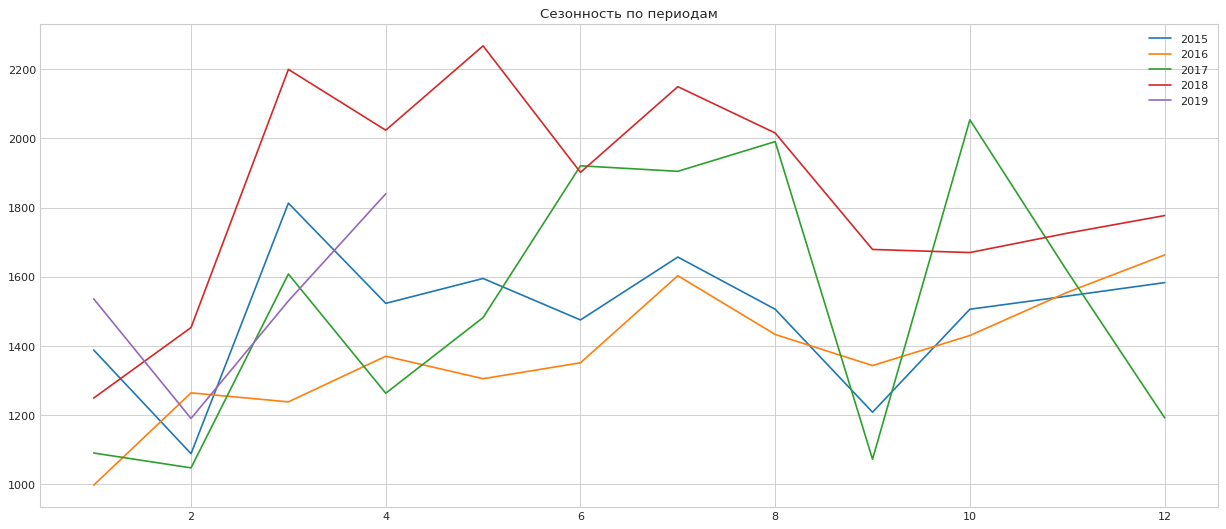

In [12]:
sesonal(df,12) #количество периодов в году, в данном случае строим по месяцам

Изучив фактические данные и результаты анализа на выбросы, делаем заключение, что выбросы есть в четырех периодах:
03-05.2018 и 07.2018. Первую точку возьмем по аналогии с 2015 годом: на сезонном графике видно, что динамика этих лет примерно совпадает. А вторую возьмем по аналогии с 07.2017 года. 

**Методические рекомендации:** *постарайтесь подробнее расписать причины отклонений и почему выбрали именно эти точки в выбросах.*

In [13]:
df.loc['2018-03-01'].Y=df.loc['2015-03-01'].Y
df.loc['2018-04-01'].Y=df.loc['2015-04-01'].Y
df.loc['2018-05-01'].Y=df.loc['2015-05-01'].Y
df.loc['2018-07-01'].Y=df.loc['2017-07-01'].Y

Оценим результаты корректировок.

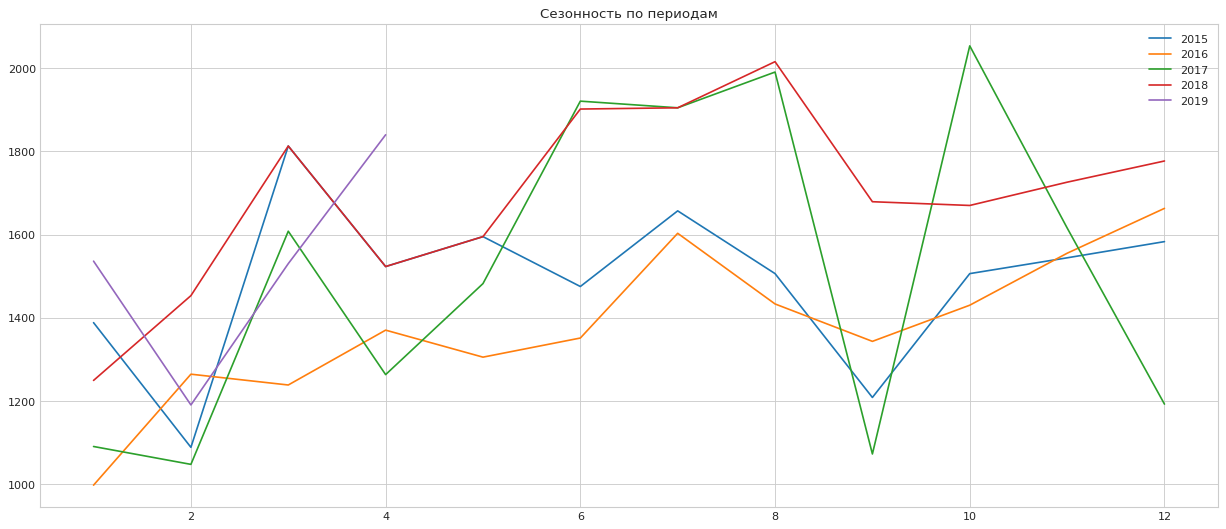

In [14]:
sesonal(df,12)

# Декомпозиция: тренд и сезонность

Оценим стабильность тренда, сезонности и возможность использования всего ряда данных. 

Оценим ряд через мультипликативную представленность. 

Text(0.5, 0.98, 'Мультипликативная модель')

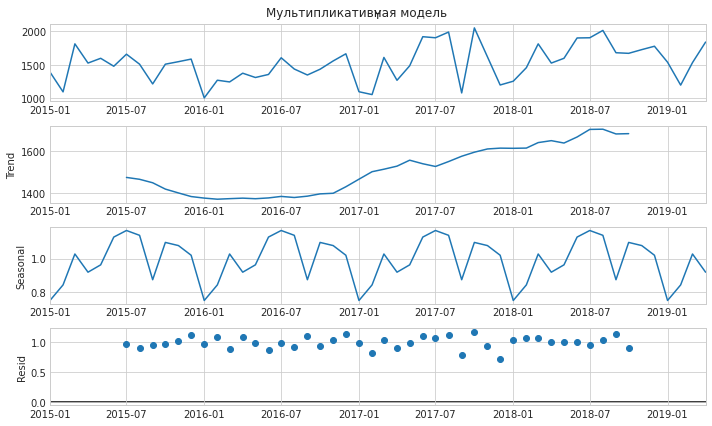

In [15]:
# декомпозиция 
result_M = seasonal_decompose(df.Y, model='multiplicative', freq=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,6)})
result_M.plot().suptitle('Мультипликативная модель')

Аддитивное разложение ряда. 

Text(0.5, 0.98, 'Аддитивная модель')

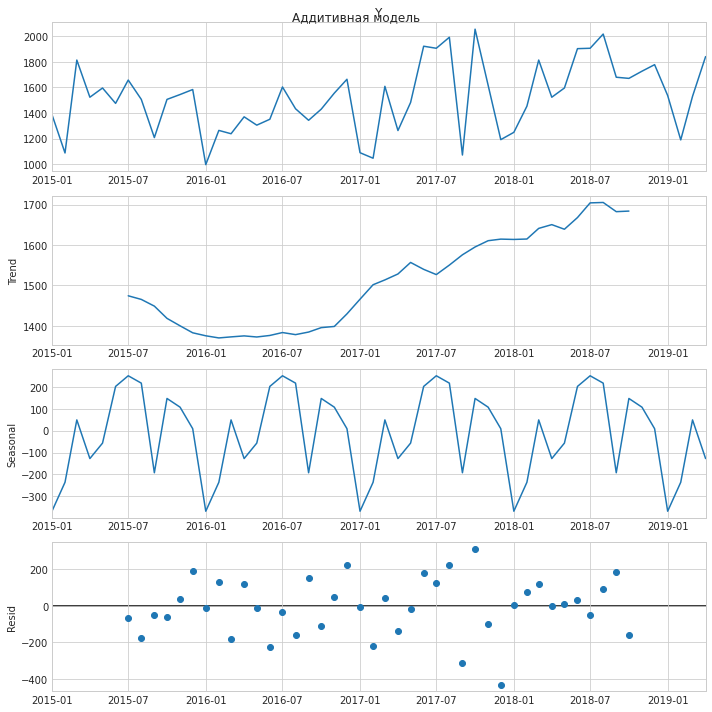

In [16]:
# Decompose 
result_A = seasonal_decompose(df.Y, model='additive', freq=12)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_A.plot().suptitle('Аддитивная модель')

Несмотря на небольшой слом тренда, будем использовать полный набор данных. Если не сможем обеспечить необходимую точность и алгоритмы не смогут "отловить" слом, можем перейти к использованию данных только с 2016 года. Ограниченный набор данных в этом случае не позволит выделить тестовую выборку.

Также, скорее всего, оптимальнее будет мультипликативная модель ряда, так как она демонстрирует более пологий тренд и меньший разброс остатков.

**Методические указания**: *постарайтесь найти ряд за пять и более лет.*

# Тренировочные и тестовые данные

Разделим данные на тренировочные и тестовые. В качестве тестовых возьмем результаты января-апреля 2019 года.

**Методические указания**: *тестовые данные обычно составляют от 5% до 20% от всего набора.*

In [17]:
train=df[:'2018']
train.head()

,Y
Xm,
2015-01-01,1388
2015-02-01,1088
2015-03-01,1813
2015-04-01,1523
2015-05-01,1595


In [18]:
test=df['2019':]
test.head()

,Y
Xm,
2019-01-01,1536
2019-02-01,1190
2019-03-01,1530
2019-04-01,1840


# Модель Хольта-Винтерса

Построим модели Хольта-Винтерса. Начнем с модели с аддитивным трендом и мультипликативной сезонностью.

In [19]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()
fit1.params

{'smoothing_level': 0.11107198482524773,
 'smoothing_trend': 0.11107192994364538,
 'smoothing_seasonal': 0.29630942749787,
 'damping_trend': nan,
 'initial_level': 1180.9992872105618,
 'initial_trend': -9.261599509824137,
 'initial_seasons': array([1.17647551, 1.06390002, 1.53593216, 1.29842571, 1.36499347,
        1.45995225, 1.56899555, 1.54839133, 1.11541928, 1.44085868,
        1.3934885 , 1.35849466]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Судя по коэффициентам сглаживания, лучшей стратегией является использование для прогноза последних результатов.

In [20]:
metrics(train, fit1.fittedvalues)

Тест на стационарность:
	T-статистика = -7.360
	P-значение = 0.000
Критические значения :
	1%: -3.5778480370438146 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.925338105429433 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6007735310095064 - Данные  стационарны с вероятностью 90% процентов
MAD: 151.9918
MSE: 41829.1129
MAPE: 0.101
MPE: 0.0153
Стандартная ошибка: 204.5217


Мы видим, что остатки стационарны, и модель можем использовать без ограничений. 

Модель является несколько переоценивающей (на 072%). Средняя абсолютная ошибка 9.38%, что в целом может быть вполне приемлемо.  

Построим варианты модели с другими видами тренда и сезонности.

In [21]:
fit2 = ExponentialSmoothing(train, seasonal_periods=12, trend='mul', seasonal='mul').fit()
metrics(train, fit2.fittedvalues)

Тест на стационарность:
	T-статистика = -7.286
	P-значение = 0.000
Критические значения :
	1%: -3.5778480370438146 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.925338105429433 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6007735310095064 - Данные  стационарны с вероятностью 90% процентов
MAD: 150.6529
MSE: 41199.5271
MAPE: 0.1006
MPE: 0.0072
Стандартная ошибка: 202.9767


In [22]:
fit3 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit()
metrics(train, fit3.fittedvalues)

Тест на стационарность:
	T-статистика = -8.097
	P-значение = 0.000
Критические значения :
	1%: -3.5778480370438146 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.925338105429433 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6007735310095064 - Данные  стационарны с вероятностью 90% процентов
MAD: 150.366
MSE: 39376.0632
MAPE: 0.1035
MPE: 0.0001
Стандартная ошибка: 198.434


In [23]:
fit4 = ExponentialSmoothing(train, seasonal_periods=12, trend='mul', seasonal='add').fit()
metrics(train, fit4.fittedvalues)

Тест на стационарность:
	T-статистика = -6.905
	P-значение = 0.000
Критические значения :
	1%: -3.5778480370438146 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.925338105429433 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6007735310095064 - Данные  стационарны с вероятностью 90% процентов
MAD: 150.1352
MSE: 41219.4182
MAPE: 0.1012
MPE: -0.0083
Стандартная ошибка: 203.0257


Наиболее точной оказалась модель (2) с мультипликативным трендом и мультипликативной сезонностью. У этой модели наименьшая среднеквадратическая ошибка, остатки стационарны.

Лучшая модель имеет среднюю абсолютную ошибку в 9.55%, на 0.53% является переоценивающей и 95% доверительный интервал +/- 344 контейнера.

Построим график фактического ряда, модели, прогноза лучшей модели и тестового набора данных. 

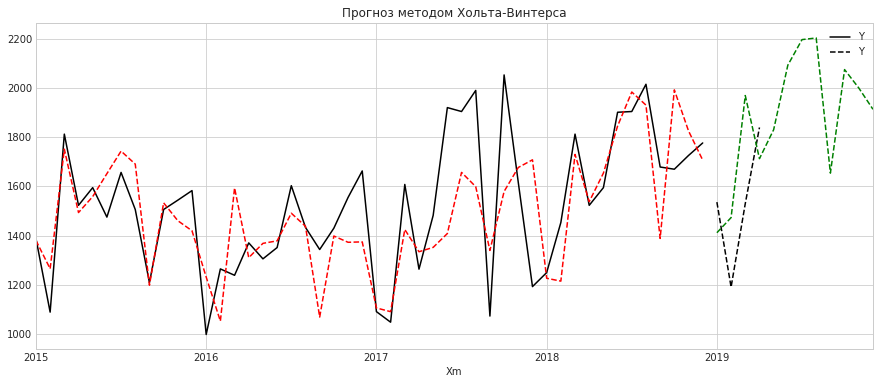

In [24]:
ax = train.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта-Винтерса")
test.plot(ax=ax, style='--', color='black')
fit2.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

Черной пунктирной линией отображен тестовый период по отношению к спрогнозированному. Надо проверить, не будут ли другие модели точнее в части предсказания тестовых данных.

In [25]:
metrics(test, fit1.forecast(len(test)))

Тест на стационарность:
	T-статистика = -1.718
	P-значение = 0.422
Критические значения :
	1%: -10.41719074074074 - Данные не стационарны с вероятностью 99% процентов
	5%: -5.77838074074074 - Данные не стационарны с вероятностью 95% процентов
	10%: -3.391681111111111 - Данные не стационарны с вероятностью 90% процентов
MAD: 243.0075
MSE: 73391.0956
MAPE: 0.1674
MPE: -0.0859
Стандартная ошибка: 270.9079


In [26]:
metrics(test, fit2.forecast(len(test)))

Тест на стационарность:
	T-статистика = -1.729
	P-значение = 0.416
Критические значения :
	1%: -10.41719074074074 - Данные не стационарны с вероятностью 99% процентов
	5%: -5.77838074074074 - Данные не стационарны с вероятностью 95% процентов
	10%: -3.391681111111111 - Данные не стационарны с вероятностью 90% процентов
MAD: 243.6313
MSE: 76336.6993
MAPE: 0.1689
MPE: -0.0938
Стандартная ошибка: 276.291


In [27]:
metrics(test, fit3.forecast(len(test)))

Тест на стационарность:
	T-статистика = -1.675
	P-значение = 0.444
Критические значения :
	1%: -10.41719074074074 - Данные не стационарны с вероятностью 99% процентов
	5%: -5.77838074074074 - Данные не стационарны с вероятностью 95% процентов
	10%: -3.391681111111111 - Данные не стационарны с вероятностью 90% процентов
MAD: 226.0073
MSE: 69627.2214
MAPE: 0.1594
MPE: -0.1044
Стандартная ошибка: 263.8697


In [28]:
metrics(test, fit4.forecast(len(test)))

Тест на стационарность:
	T-статистика = -1.680
	P-значение = 0.442
Критические значения :
	1%: -10.41719074074074 - Данные не стационарны с вероятностью 99% процентов
	5%: -5.77838074074074 - Данные не стационарны с вероятностью 95% процентов
	10%: -3.391681111111111 - Данные не стационарны с вероятностью 90% процентов
MAD: 230.5874
MSE: 72209.0523
MAPE: 0.1628
MPE: -0.1062
Стандартная ошибка: 268.7174


К сожалению, даже лучшая модель не очень хорошо дает прогноз на будущий период по отношению к модели (1), с аддитивным трендом и мультипликативной сезонностью демонстрирует лучшие результаты. Построим ее график.

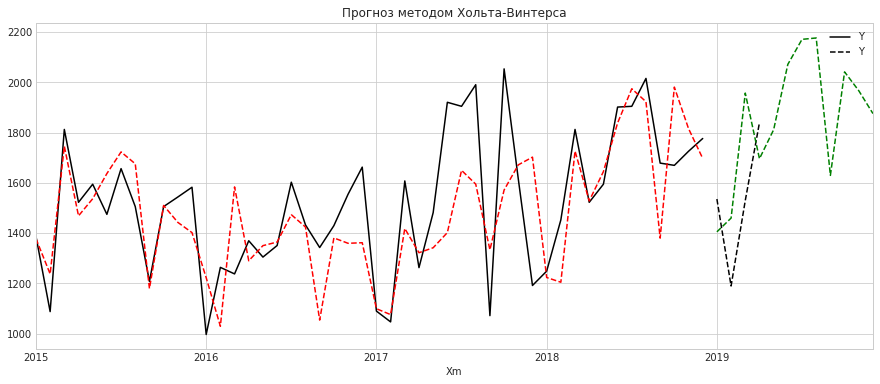

In [29]:
ax = train.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта-Винтерса")
test.plot(ax=ax, style='--', color='black')
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

Попробуем построить более точную модель по методу SARIMA.

# SARIMA

Сделаем прогноз методом SARIMA. Но предварительно изучим данные на предмет наличия автокорреляции в ряду.

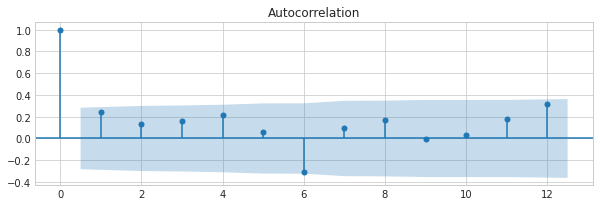

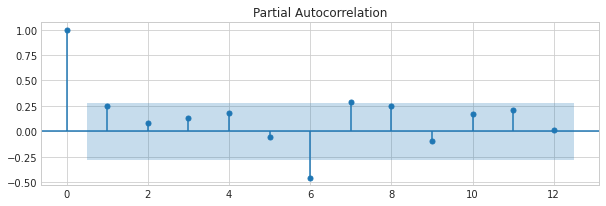

In [30]:
plt.rcParams.update({'figure.figsize': (10,3)})
plot_acf(train.Y, lags=12)
plot_pacf(train.Y, lags=12)
plt.show()

На графике автокорреляции мы видим, что в ряду содержится очень слабый тренд. И сезонность не каждые 12 месяцев, а 6 месяцев. Это некоторое исключение.

Попробуем подобрать параметры модели.

In [31]:
model = auto_arima(train, seasonal=True, m=6, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=683.326, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=658.993, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=653.255, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=681.355, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,1)(0,0,2)[6] intercept   : AIC=651.009, Time=0.24 sec
 ARIMA(0,1,1)(1,0,2)[6] intercept   : AIC=652.994, Time=0.40 sec
 ARIMA(0,1,0)(0,0,2)[6] intercept   : AIC=669.226, Time=0.19 sec
 ARIMA(1,1,1)(0,0,2)[6] intercept   : AIC=652.978, Time=0.29 sec
 ARIMA(0,1,2)(0,0,2)[6] intercept   : AIC=652.977, Time=0.30 sec
 ARIMA(1,1,0)(0,0,2)[6] intercept   : AIC=660.409, Time=0.12 sec
 ARIMA(1,1,2)(0,0,2)[6] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,1)(0,0,2)[6]             : AIC=650.031, Time=0.12 se

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 2, 6),
      suppress_warnings=True, with_intercept=False)

In [32]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(0, 1, 1),
                                seasonal_order=(0, 0, 2, 6))

results = mod.fit()

print(results.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      Y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 6)   Log Likelihood                -321.016
Date:                                Wed, 30 Jun 2021   AIC                            650.031
Time:                                        05:17:51   BIC                            657.432
Sample:                                    01-01-2015   HQIC                           652.816
                                         - 12-01-2018                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7372      0.125     -5.907      0.000      -0.982      -0.493
ma.

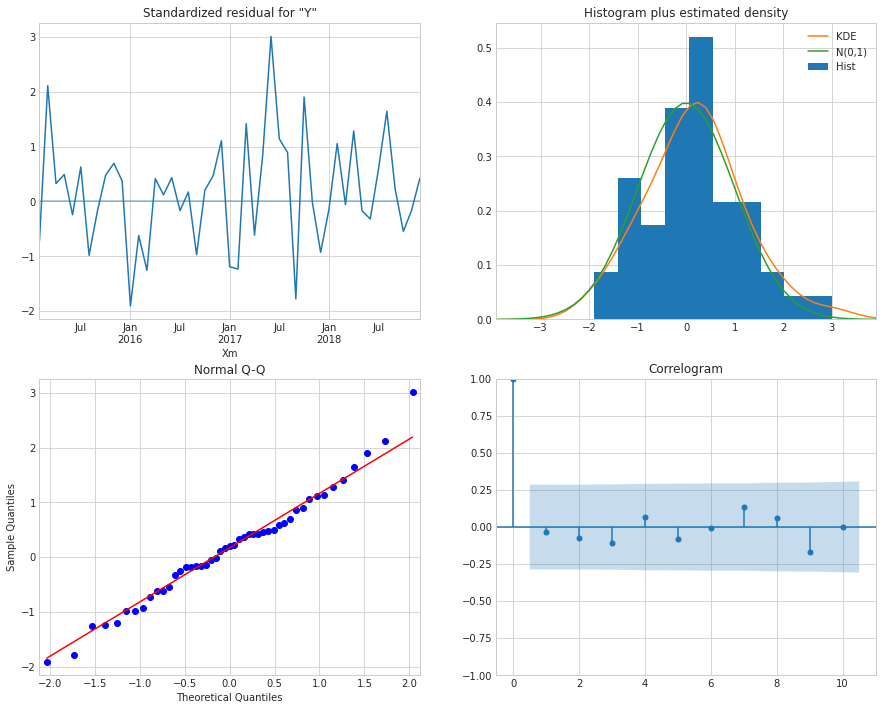

In [33]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Остатки случайны, закономерностей нет. Распределение в целом нормальное.

In [34]:
results.fittedvalues

Xm
2015-01-01       0.000000
2015-02-01    1322.824234
2015-03-01    1202.732590
2015-04-01    1432.789197
2015-05-01    1461.658913
2015-06-01    1540.019467
2015-07-01    1496.434299
2015-08-01    1736.581174
2015-09-01    1249.669450
2015-10-01    1399.095176
2015-11-01    1389.462291
2015-12-01    1500.691222
2016-01-01    1418.274728
2016-02-01    1401.009456
2016-03-01    1514.582499
2016-04-01    1278.345437
2016-05-01    1278.461863
2016-06-01    1255.829476
2016-07-01    1638.908666
2016-08-01    1395.764304
2016-09-01    1551.972212
2016-10-01    1385.942755
2016-11-01    1454.283238
2016-12-01    1425.063695
2017-01-01    1344.459566
2017-02-01    1309.738214
2017-03-01    1306.326609
2017-04-01    1393.538663
2017-05-01    1300.429132
2017-06-01    1282.025321
2017-07-01    1662.735405
2017-08-01    1801.481060
2017-09-01    1448.958132
2017-10-01    1649.643105
2017-11-01    1619.891437
2017-12-01    1389.008620
2018-01-01    1279.689203
2018-02-01    1229.351851
2018-03-0

Так как используется скользящая средняя, модель не может делать прогнозы для первой даты. Сравним точность начиная со второго периода. 

In [35]:
predict=results.get_prediction(start=pd.to_datetime('2015-02-01'))
metrics(train['2015-02-01':], predict.predicted_mean)

Тест на стационарность:
	T-статистика = -7.169
	P-значение = 0.000
Критические значения :
	1%: -3.5812576580093696 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.9267849124681518 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6015409829867675 - Данные  стационарны с вероятностью 90% процентов
MAD: 174.7253
MSE: 51098.3072
MAPE: 0.1192
MPE: 0.0058
Стандартная ошибка: 226.0493


Остатки стационарны, точность несколько ниже на тренировочных данных, чем у модели Хольта-Винтерса. Сравним результаты с тестовыми данными и построим график. 

In [36]:
metrics(test, results.forecast(len(test)))

Тест на стационарность:
	T-статистика = -1.250
	P-значение = 0.652
Критические значения :
	1%: -10.41719074074074 - Данные не стационарны с вероятностью 99% процентов
	5%: -5.77838074074074 - Данные не стационарны с вероятностью 95% процентов
	10%: -3.391681111111111 - Данные не стационарны с вероятностью 90% процентов
MAD: 179.0044
MSE: 53546.7585
MAPE: 0.1357
MPE: -0.1357
Стандартная ошибка: 231.4017


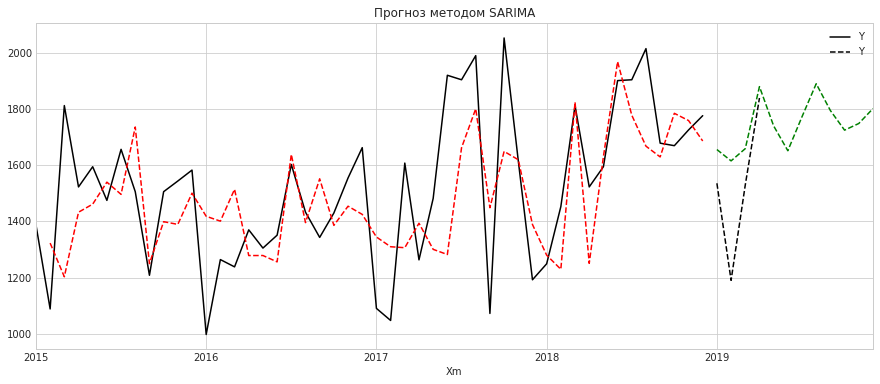

In [37]:
ax = train.plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA" )
test.plot(ax=ax, style='--', color='black')
predict.predicted_mean.plot(ax=ax, style='--', color='red')
results.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

Мы видим, что хотя в целом модель ARIMA оказалась менее точной при сравнении с тренировочными данными, на тестовых, если судить по среднеквадратическому отклонению, она оказалась чуть более точной. Здесь можем не обращать внимание на стационарность остатков, так как ряд очень короткий.

В целом точность прогноза тестовых данных неудовлетворительная. Возможно, это связано с нечеткой сезонностью ряда. Попробуем укрупнить данные до кварталов и построить прогнозные модели.

# Кварталы


Укрупняем данные до кварталов. Так как у нас за 2019 год данные только за 4 месяца, то получится один квартал.

In [38]:
df=df[:"2019-03-01"].resample('Q').sum()

Проведем валидацию данных на отсутствие пропусков.

In [39]:
df = validate_series(df)
print(df)

               Y
Xm              
2015-03-31  4289
2015-06-30  4593
2015-09-30  4371
2015-12-31  4633
2016-03-31  3499
2016-06-30  4026
2016-09-30  4379
2016-12-31  4648
2017-03-31  3745
2017-06-30  4666
2017-09-30  4968
2017-12-31  4862
2018-03-31  4515
2018-06-30  5020
2018-09-30  5600
2018-12-31  5173
2019-03-31  4256


Построим график и посмотрим основные параметры нашего ряда. 

[<AxesSubplot:>]

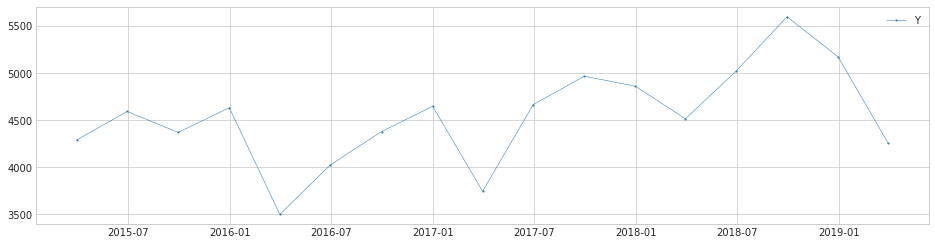

In [40]:
plot(df)

In [41]:
df.describe()

,Y
count,17.000000
mean,4543.705882
std,515.932864
min,3499.000000
25%,4289.000000
50%,4593.000000
75%,4862.000000
max,5600.000000


Отобразим точки на графике, которые больше 6100 контейнеров в квартал и меньше 3600.

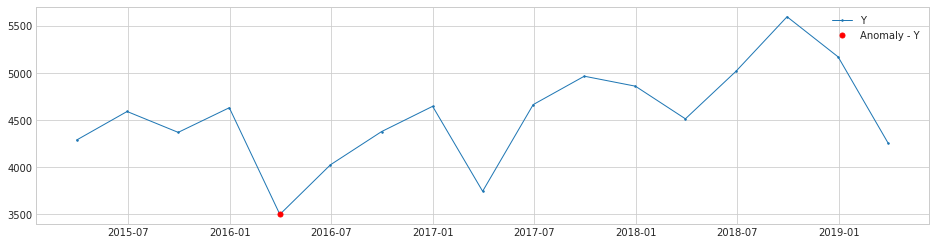

In [42]:
threshold_ad = ThresholdAD(high=6100, low=3600)
anomalies = threshold_ad.detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

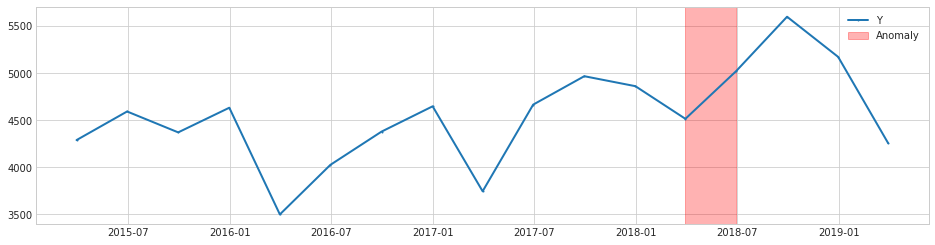

In [43]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.06))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

In [44]:
anomalies[anomalies]

Xm
2018-03-31    True
Freq: Q-DEC, dtype: bool

Детектор аномалий при уровне чувствительности 0.6 показывает одну аномалию в 4-м квартале 2017 года. 

Взглянем на сезонную компоненту. 

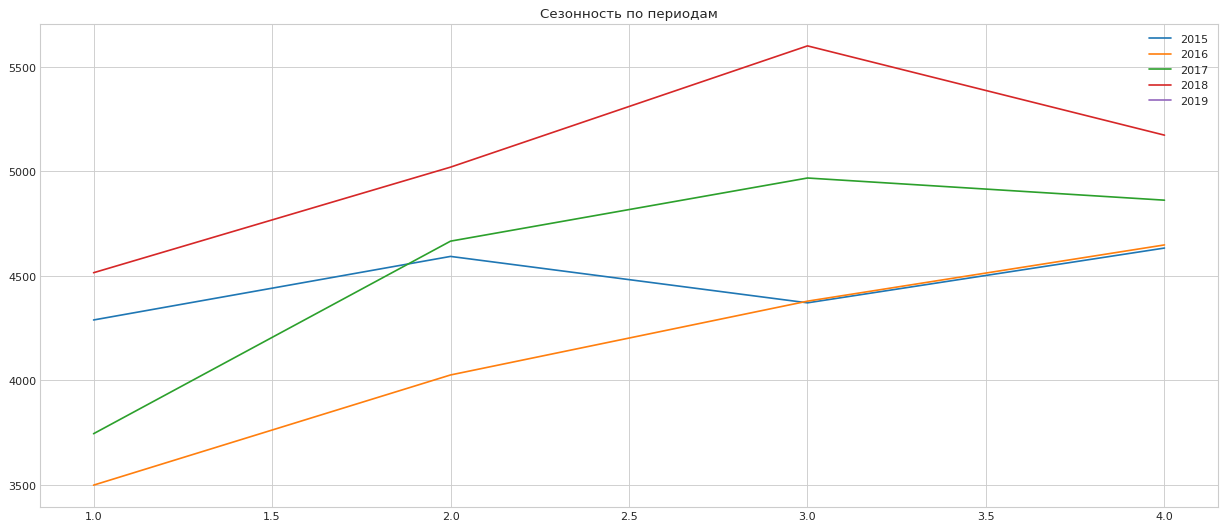

In [45]:
sesonal(df,4)

Четвертый квартал 2017 года несколько ниже, чем ожидается. График подтверждает выброс, выявленый детектором аномалий. Попробуем несколько исправить положение, присвоив четвертому кварталу среднее значение третьего квартала 2017 года и первого 2018 года.

In [46]:
df.loc['2017-12-31']=(df.loc['2017-09-30']+df.loc['2018-03-31'])/2

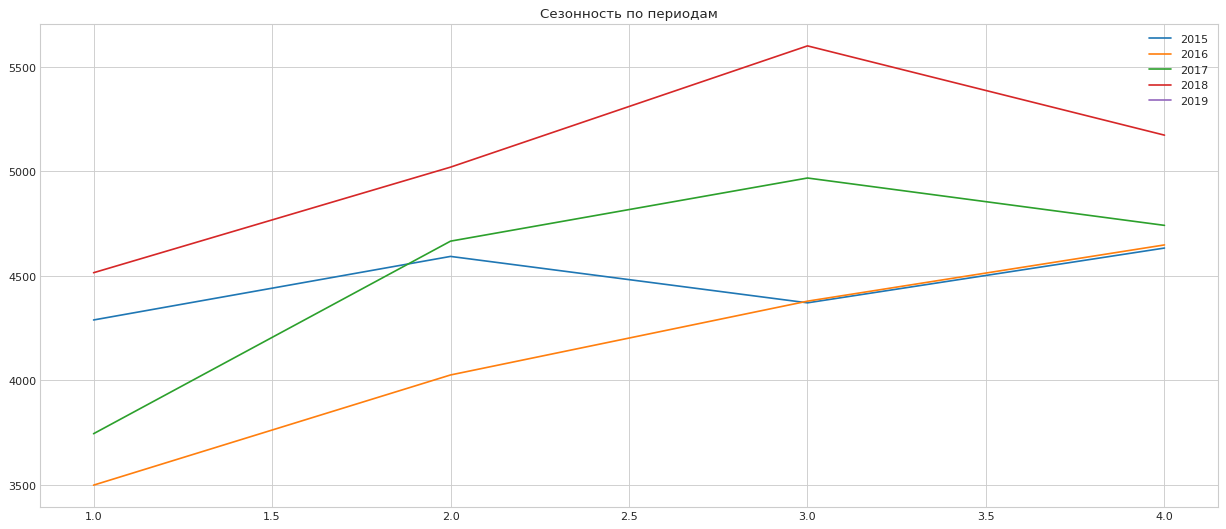

In [47]:
sesonal(df,4)

Мы помним, что корректировки вносились в месячные данные. Не стоит повторно прибегать к ним. Или, при необходимости, сделаем их на оригинальном ряду. 

В целом очевидно, что 2019 год уже является нестандартным. Но, к сожалению, у нас слишком мало данных, чтобы говорить о среднесрочных циклах или однозначной аномалии.

# Декомпозиция: тест и сезонность

Выполним декомпозицию по мультипликативной и аддитивной моделям.

Text(0.5, 0.98, 'Мультипликативная модель')

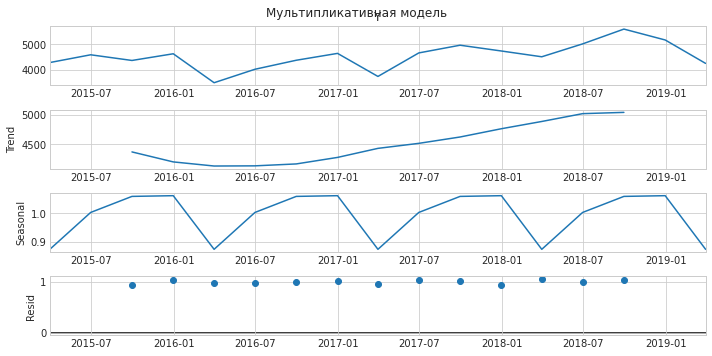

In [48]:
# декомпозиция 
result_M = seasonal_decompose(df.Y, model='multiplicative', freq=4)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,5)})
result_M.plot().suptitle('Мультипликативная модель')

Text(0.5, 0.98, 'Аддитивная модель')

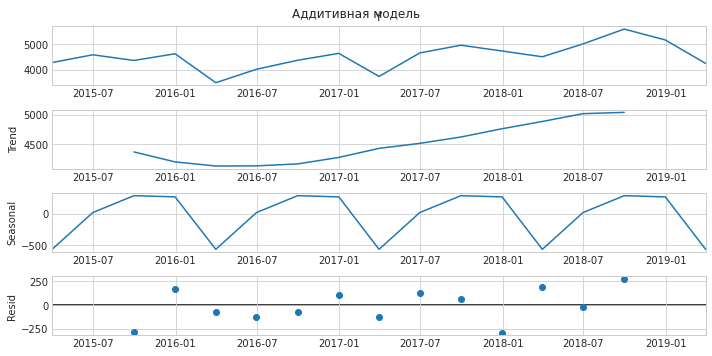

In [49]:
# Decompose 
result_A = seasonal_decompose(df.Y, model='additive', freq=4)

# Plot
plt.rcParams.update({'figure.figsize': (10,5)})
result_A.plot().suptitle('Аддитивная модель')

В ряду мы наблюдаем явный как тренд, так и сезонную компоненту. Визуально и аддитивная, и мультипликативная модели выглядят одинаково предпочтительно.

# Тренировочные и тестовые данные

Разделим данные на тренировочные и тестовые. В качестве тестовых возьмем три последних квартала.

In [50]:
train=df[:'2018-06-30']
train.tail()

,Y
Xm,
2017-06-30,4666.0
2017-09-30,4968.0
2017-12-31,4741.5
2018-03-31,4515.0
2018-06-30,5020.0


In [51]:
test=df['2018-09-30':]
test.head()

,Y
Xm,
2018-09-30,5600.0
2018-12-31,5173.0
2019-03-31,4256.0


# Модель Хольта-Винтерса

Построим четыре варианта модели Хольта-Винтерса.

In [52]:
fit1 = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='mul').fit()
metrics(train, fit1.fittedvalues)

Тест на стационарность:
	T-статистика = -3.355
	P-значение = 0.013
Критические значения :
	1%: -4.6651863281249994 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.3671868750000002 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.802960625 - Данные  стационарны с вероятностью 90% процентов
MAD: 267.083
MSE: 99125.1733
MAPE: 0.0604
MPE: 0.0249
Стандартная ошибка: 314.8415


In [53]:
fit2 = ExponentialSmoothing(train, seasonal_periods=4, trend='mul', seasonal='mul').fit()
metrics(train, fit2.fittedvalues)

Тест на стационарность:
	T-статистика = -3.070
	P-значение = 0.029
Критические значения :
	1%: -4.6651863281249994 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.3671868750000002 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.802960625 - Данные  стационарны с вероятностью 90% процентов
MAD: 263.2738
MSE: 99087.9088
MAPE: 0.0598
MPE: 0.0061
Стандартная ошибка: 314.7823


In [54]:
fit3 = ExponentialSmoothing(train, seasonal_periods=4, trend='mul', seasonal='add').fit()
metrics(train, fit3.fittedvalues)

Тест на стационарность:
	T-статистика = -3.162
	P-значение = 0.022
Критические значения :
	1%: -4.6651863281249994 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.3671868750000002 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.802960625 - Данные  стационарны с вероятностью 90% процентов
MAD: 241.4923
MSE: 90285.9805
MAPE: 0.0552
MPE: 0.019
Стандартная ошибка: 300.4763


In [55]:
fit4 = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='add').fit()
metrics(train, fit4.fittedvalues)

Тест на стационарность:
	T-статистика = -3.672
	P-значение = 0.005
Критические значения :
	1%: -4.6651863281249994 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.3671868750000002 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.802960625 - Данные  стационарны с вероятностью 90% процентов
MAD: 238.6397
MSE: 86843.5955
MAPE: 0.0542
MPE: 0.0196
Стандартная ошибка: 294.6924


По оценке на тренировочных данных у модели (4) с аддитивным трендом и аддитивной сезонностью выше точность. Проверим модели на тестовых данных.

In [56]:
metrics_short(test, fit1.forecast(len(test)))

MAD: 343.1246
MSE: 134588.5667
MAPE: 0.0724
MPE: -0.0417
Стандартная ошибка: 366.8631


In [57]:
metrics_short(test, fit2.forecast(len(test)))

MAD: 347.9621
MSE: 140544.7512
MAPE: 0.0736
MPE: -0.0429
Стандартная ошибка: 374.893


In [58]:
metrics_short(test, fit3.forecast(len(test)))

MAD: 334.7101
MSE: 140845.9366
MAPE: 0.0703
MPE: -0.0272
Стандартная ошибка: 375.2945


In [59]:
metrics_short(test, fit4.forecast(len(test)))

MAD: 356.8716
MSE: 153603.427
MAPE: 0.0751
MPE: -0.034
Стандартная ошибка: 391.9227


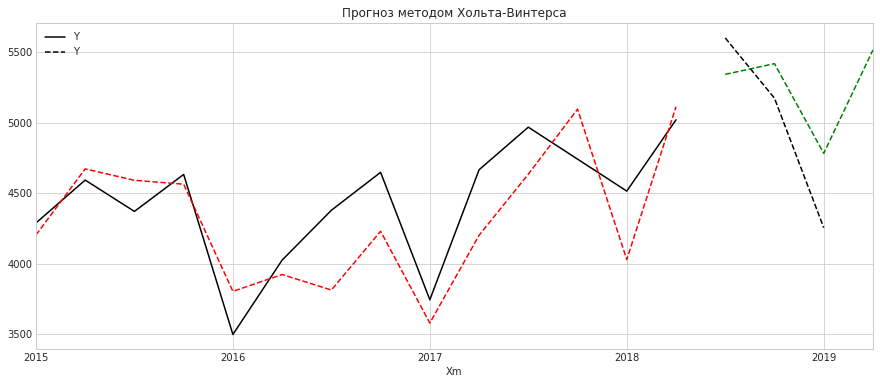

In [60]:
ax = train.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта-Винтерса")
test.plot(ax=ax, style='--', color='black')
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(4).plot(ax=ax, style='--', color='green')
plt.show()

Мы видим, что модель (1) показала неплохой результат в части сопоставления с тестовыми данными. Точность составила в среднем 8.8%, что выше, чем в случае с месячными данными. В целом квартальная модель показывает себя более точной, что и следовало ожидать. 

# SARIMA

Построим поквартальную модель методом SARIMA.

Изучим результаты автокорреляции. 

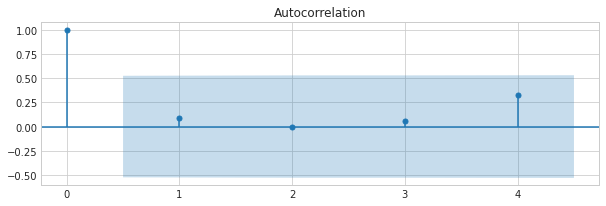

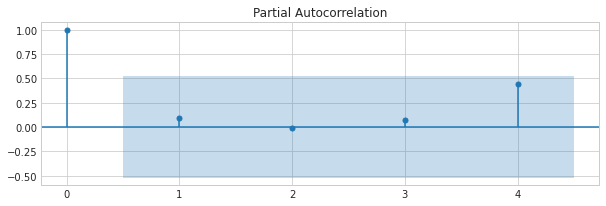

In [61]:
plt.rcParams.update({'figure.figsize': (10,3)})
plot_acf(train.Y, lags=4)
plot_pacf(train.Y, lags=4)
plt.show()

Что интересно, модель автокорреляции указывает скорее на среднесрочные циклы 5, 7 и 8 кварталов. Но данных, чтобы делать подобные заключения, у нас маловато. Четкого тренда и квартальной сезонности статистически не видно, но попробуем использовать сезонную модель. 

In [62]:
model = auto_arima(train, seasonal=True, m=4, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=219.031, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=212.675, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=215.898, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=276.979, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=214.661, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=214.585, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=214.555, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=217.109, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[4] intercept
Total fit time: 0.977 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 4),
      suppress_warnings=True)

Лучшая по автоподбору модель (order=(0, 0, 0), seasonal_order=(0, 0, 0, 4)) оказалась нерелевантна при построении. Мы методом перебора выбрали иную из предложенных автоподбором.

In [63]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(0, 0, 0),
                                seasonal_order=(0, 0, 0, 4))

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.985e+07    5.9e+07      0.336      0.737   -9.58e+07    1.35e+08


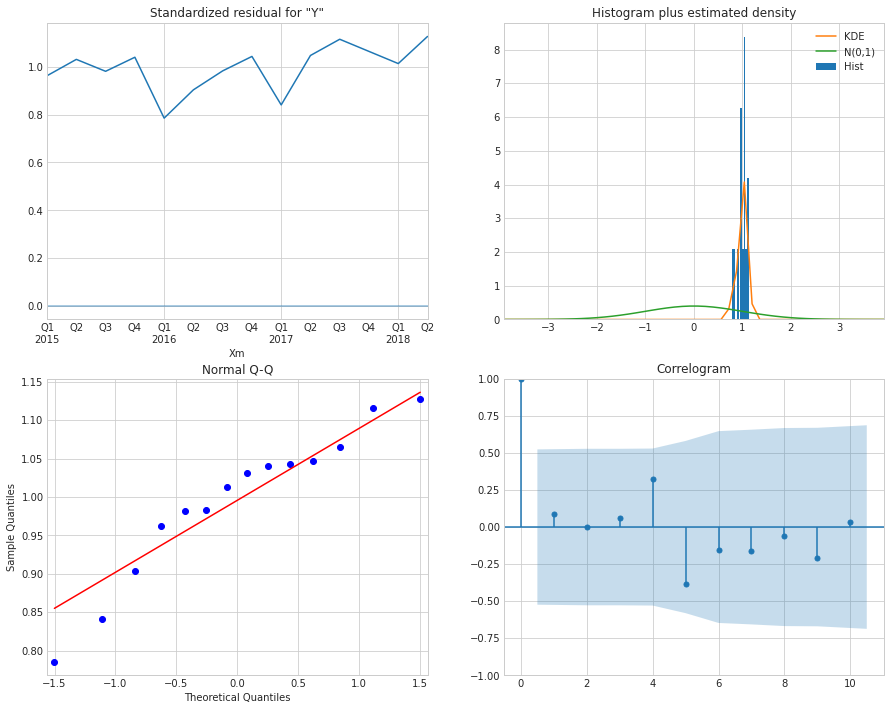

In [64]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Остатки стационарные, если судить по диагностической модели. Есть незначительные выбросы в распределении остатков.

Выведем результат моделирования. 

In [65]:
results.fittedvalues

Xm
2015-03-31    0.0
2015-06-30    0.0
2015-09-30    0.0
2015-12-31    0.0
2016-03-31    0.0
2016-06-30    0.0
2016-09-30    0.0
2016-12-31    0.0
2017-03-31    0.0
2017-06-30    0.0
2017-09-30    0.0
2017-12-31    0.0
2018-03-31    0.0
2018-06-30    0.0
Freq: Q-DEC, dtype: float64

Так как модель использует скользящую среднюю, нет прогноза для первого квартала. Оценим точность модели на тренировочных данных.

In [66]:
predict=results.get_prediction(start=pd.to_datetime('2015-06-30'))
metrics(train['2015-06-30':], predict.predicted_mean)

Тест на стационарность:
	T-статистика = -0.387
	P-значение = 0.912
Критические значения :
	1%: -4.6651863281249994 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.3671868750000002 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.802960625 - Данные не стационарны с вероятностью 90% процентов
MAD: 4446.5
MSE: 19957096.4038
MAPE: 1.0
MPE: 1.0
Стандартная ошибка: 4467.3366


Как мы видим, остатки не стационарны. Мы не можем использовать эту модель для прогнозирования. Но ради любопытства попробуем сравнить ее результаты с тестовыми данными. 

In [67]:
metrics_short(test, results.forecast(len(test)))

MAD: 5009.6667
MSE: 25411155.0
MAPE: 1.0
MPE: 1.0
Стандартная ошибка: 5040.9478


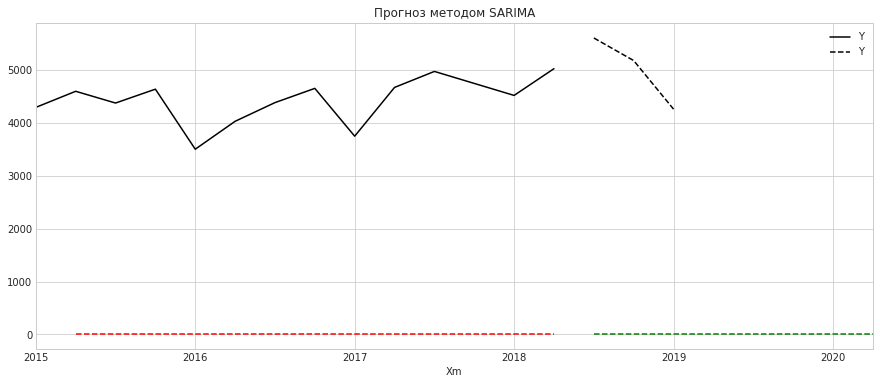

In [68]:
ax = train.plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA")
test.plot(ax=ax, style='--', color='black')
predict.predicted_mean.plot(ax=ax, style='--', color='red')
results.forecast(8).plot(ax=ax, style='--', color='green')
plt.show()

Как мы видим, действительно, модель неадекватна. Ее движение расходится с фактическими значениями, и модель вырождается в прямую. 

Прежде чем делать выводы, попробуем объяснить колебания ряда через другие переменные.

# Множественная линейная регрессия

**Методические указания**: *не обязательно для выполнения в рамках межмодульной работы*

Прочитаем с листа RG данные для регрессии. 

In [69]:
dfR=pd.read_excel("sample_dataset.xlsx",  sheet_name='RG')
dfR.head()

,Xm,N,Y,Сортировка контейнеров,Ср.сут. кол-во вагонов,Цена,Расходы на рекламу
0,2015-01-01,1,1388,117,25,50,125
1,2015-02-01,2,1088,119,25,50,125
2,2015-03-01,3,1813,124,27,50,200
3,2015-04-01,4,1523,126,29,50,200
4,2015-05-01,5,1595,127,30,50,250


N – номер квартала по порядку, будет задавать тренд. Также количество отсортированных контейнеров, среднесуточное количество вагонов, стоимость и расходы на рекламу. 

In [70]:
dfR.describe()

,N,Y,Сортировка контейнеров,Ср.сут. кол-во вагонов,Цена,Расходы на рекламу
count,48.00,48.000000,48.000000,48.000000,48.000000,48.000000
mean,24.50,1558.187500,131.979167,31.145833,65.000000,191.666667
std,14.00,321.445979,11.170801,5.418603,11.298654,51.913731
min,1.00,997.000000,117.000000,18.000000,50.000000,125.000000
25%,12.75,1333.500000,125.750000,27.750000,57.500000,125.000000
50%,24.50,1533.500000,130.000000,32.000000,65.000000,200.000000
75%,36.25,1738.750000,137.250000,35.000000,72.500000,250.000000
max,48.00,2268.000000,162.000000,42.000000,80.000000,250.000000


Мы видим, что в данных нет пропусков. Посмотрим на нормальность распределения количества обработанных контейнеров (Y).

<AxesSubplot:xlabel='Y', ylabel='Density'>

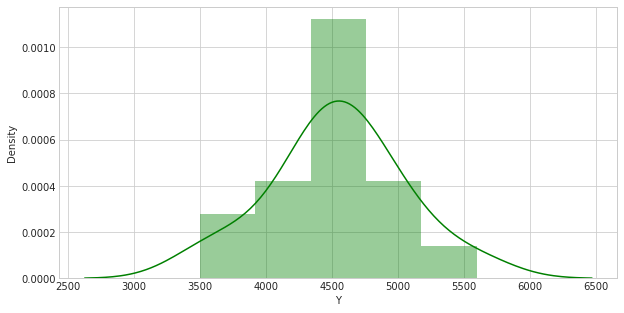

In [71]:
plt.figure(figsize=(10,5))
sns.distplot(df['Y'], color='g', hist_kws={'alpha':0.4}, bins=5)

Мы видим, что количество обработанных контейнеров имеет нормальное распределение. 

Посмотрим на парные распределения и зависимости.

In [72]:
dfR.columns

Index(['Xm', 'N', 'Y', 'Сортировка контейнеров', 'Ср.сут. кол-во вагонов',
       'Цена', 'Расходы на рекламу'],
      dtype='object')

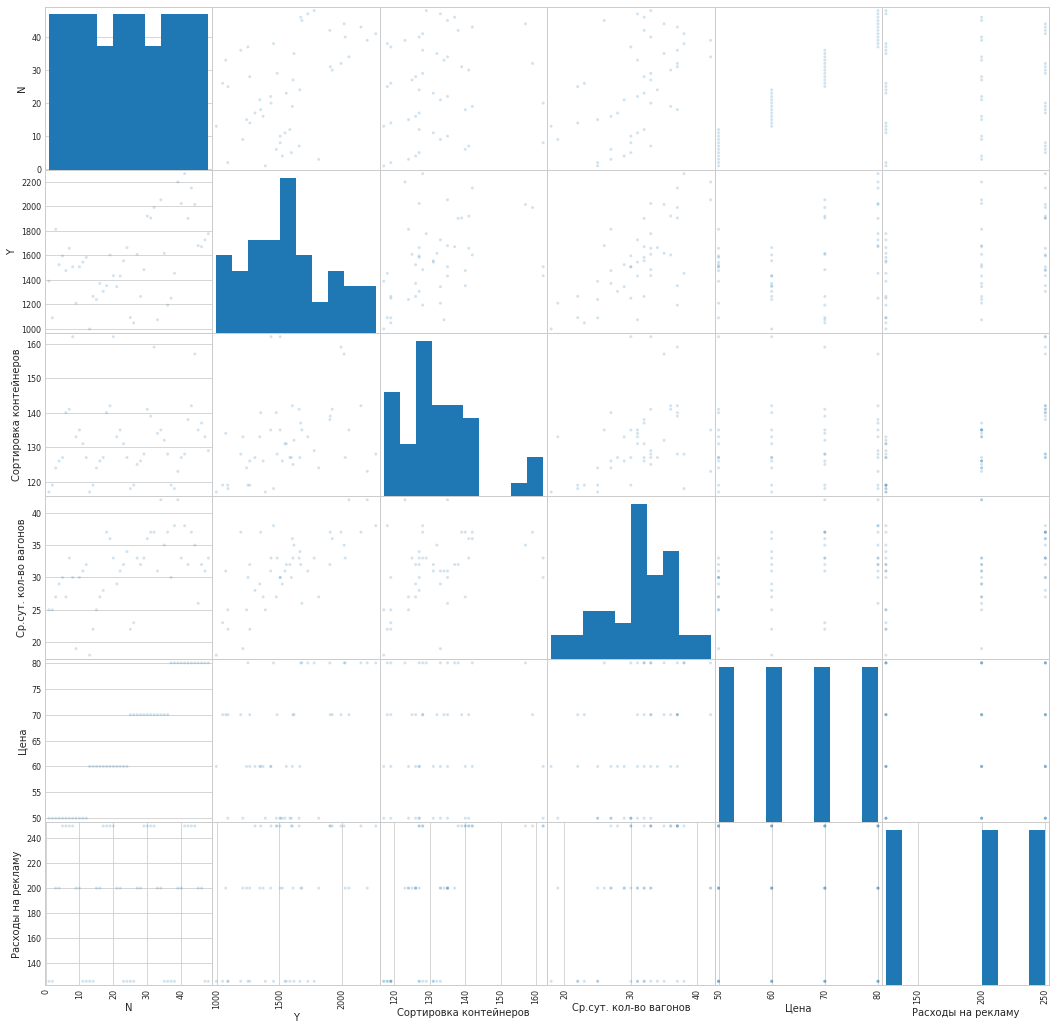

In [73]:
scatter_matrix(dfR[['N', 'Y', 'Сортировка контейнеров', 'Ср.сут. кол-во вагонов',
       'Цена', 'Расходы на рекламу']], figsize=(18,18), alpha=0.2);

Судя по распределению, "Сортировка контейнеров" может быть причиной аномалий.

Посмотрим на парные корреляции. 

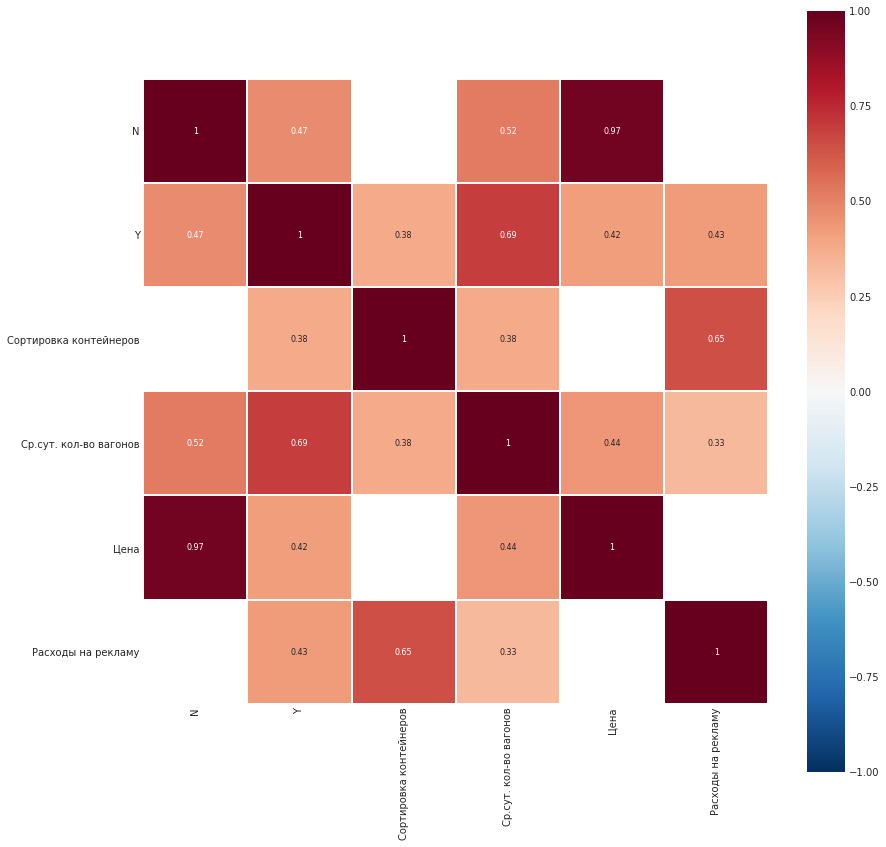

In [74]:
h_map(dfR, 0.3)

<Figure size 1008x1008 with 0 Axes>

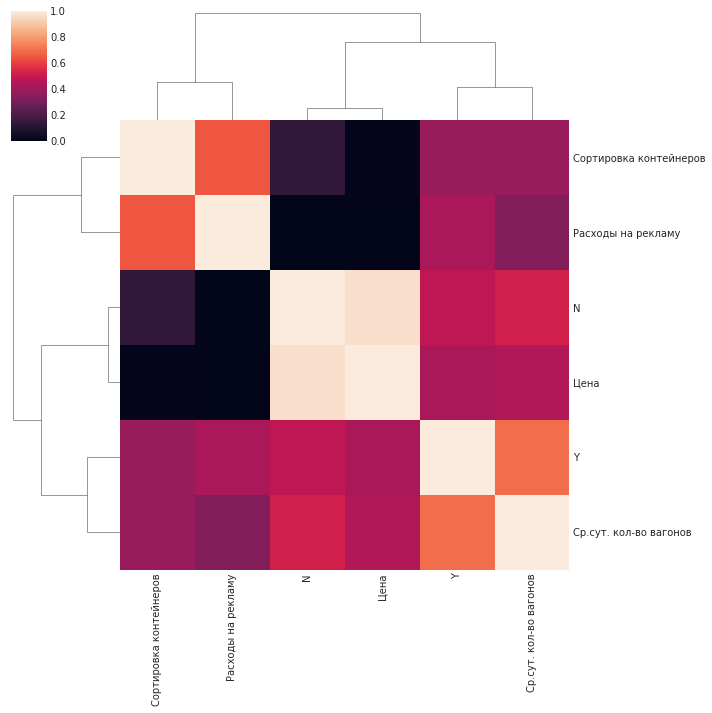

In [75]:
plt.figure(figsize=(14,14))
sns.clustermap(dfR.corr())

Скорее всего, мы столкнемся с эффектом мультиколлинеарности. В частности, цена и порядковый номер имеют высокую взаимозависимость.

In [76]:
dfR.columns

Index(['Xm', 'N', 'Y', 'Сортировка контейнеров', 'Ср.сут. кол-во вагонов',
       'Цена', 'Расходы на рекламу'],
      dtype='object')

In [77]:
col=['N', 'Сортировка контейнеров', 'Ср.сут. кол-во вагонов',
       'Цена', 'Расходы на рекламу']
#Разделим на влияющую и целевую переменные
X=dfR[col]
Y=dfR['Y']

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     10.59
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           1.26e-06
Time:                        05:18:04   Log-Likelihood:                -325.12
No. Observations:                  48   AIC:                             662.2
Df Residuals:                      42   BIC:                             673.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    539

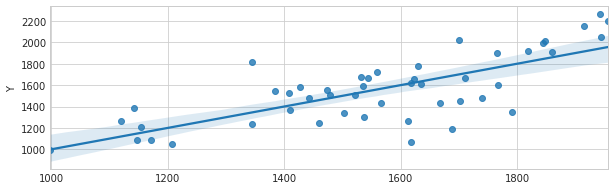

In [78]:
X=sm.add_constant(X)

reg = sm.OLS(Y, X)
res=reg.fit()
print(res.summary())
r=res.predict(X)
r=np.array(res)
sns.regplot(res.fittedvalues.copy(), Y)
plt.show()

Как и ожидали, мы не можем использовать модель со всем набором данных. Выполним перебор параметров и найдем оптимальную модель.

In [79]:
res=get_factors(dfR[col], dfR['Y'], col)

Количество комбинаций  32
Результаты перебора в порядке возрастания MSE:
          MSE        r2                      Переменные
0  60462.1998  0.402399  [N, Расходы на рекламу, const]
1  78796.4952  0.221185                      [N, const]
2  82840.5653  0.181214     [Расходы на рекламу, const]
3  83242.2974  0.177243                   [Цена, const]


In [80]:
res.loc[0]

MSE                               60462.1998
r2                                  0.402399
Переменные    [N, Расходы на рекламу, const]
Name: 0, dtype: object

Вверху параметры лучшей модели. Невысокий показатель R2. Попробуем построить модель.

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     15.15
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           9.32e-06
Time:                        05:18:05   Log-Likelihood:                -332.34
No. Observations:                  48   AIC:                             670.7
Df Residuals:                      45   BIC:                             676.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
N                     10.7984      2

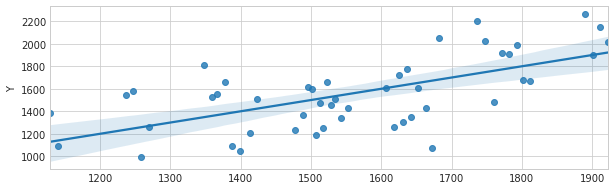

In [81]:
Y=dfR['Y']
dfR=sm.add_constant(dfR)
#укажем переменные, которые будем использовать в качестве регрессоров
X=dfR[['N', 'Расходы на рекламу', 'const']]
reg = sm.OLS(Y, X)
res=reg.fit()
print(res.summary())
sns.regplot(res.fittedvalues.copy(), Y)
plt.show()

In [82]:
metrics(dfR.Y, res.fittedvalues)

Тест на стационарность:
	T-статистика = -5.725
	P-значение = 0.000
Критические значения :
	1%: -3.5778480370438146 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.925338105429433 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6007735310095064 - Данные  стационарны с вероятностью 90% процентов
MAD: 207.1159
MSE: 60462.1998
MAPE: 0.1413
MPE: -0.0264
Стандартная ошибка: 245.8906


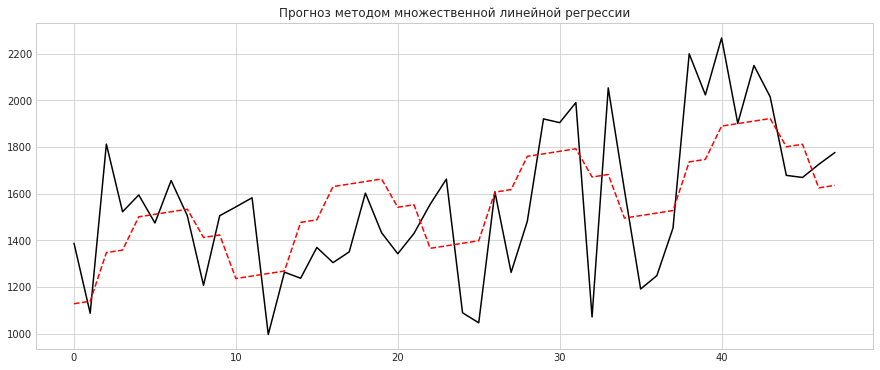

In [83]:
ax = dfR.Y.plot(figsize=(15,6), color='black', title="Прогноз методом множественной линейной регрессии" )
res.fittedvalues.plot(ax=ax, style='--', color='red')
plt.show()

Модель множественной линейной регрессии – лучшая в настоящее время по точности прогноза. Есть потенциал для ее улучшения. Но использовать ее мы не можем, так как у нас отсутствует план инвестиций в рекламу. 

# Общие выводы и корректировка

Лучше всего себя показала модель Хольта-Винтерса (аддитивный тренд и мультипликативная сезонность), где использовались данные по кварталам.

Натренируем модель на полном масштабе данных и сделаем прогноз на четыре квартала вперед.

На всякий случай прочитаем оригинальные данные и выполним корректировки.

In [84]:
df=pd.read_excel("sample_dataset.xlsx", index_col='Xm', sheet_name='Data')
df.head()

,Y
Xm,
2015-01-01,1388
2015-02-01,1088
2015-03-01,1813
2015-04-01,1523
2015-05-01,1595


In [85]:
df.loc['2018-03-01'].Y=df.loc['2015-03-01'].Y
df.loc['2018-04-01'].Y=df.loc['2015-04-01'].Y
df.loc['2018-05-01'].Y=df.loc['2015-05-01'].Y
df.loc['2018-07-01'].Y=df.loc['2017-07-01'].Y

In [86]:
df=df[:"2019-03-01"].resample('Q').sum()

In [87]:
df.loc['2017-12-31']=(df.loc['2017-09-30']+df.loc['2018-03-31'])/2

In [88]:
fit1 = ExponentialSmoothing(df, seasonal_periods=4, trend='add', seasonal='mul').fit()
metrics(df, fit1.fittedvalues)

Тест на стационарность:
	T-статистика = -3.494
	P-значение = 0.008
Критические значения :
	1%: -3.9240193847656246 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.0684982031250003 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.67389265625 - Данные  стационарны с вероятностью 90% процентов
MAD: 262.3671
MSE: 97850.8371
MAPE: 0.0584
MPE: 0.0056
Стандартная ошибка: 312.8112


In [89]:
forecast=fit1.forecast(4)
forecast

2019-06-30    4965.863176
2019-09-30    5325.209306
2019-12-31    4994.665143
2020-03-31    4506.710048
Freq: Q-DEC, dtype: float64

Считаю, что осуществление реконструкции терминала и повышение расходов на рекламу позволят достичь результата на 10% больше математического.

In [90]:
forecast.loc['2019-12-31']=5007*1.1
forecast.loc['2020-03-31']=4536*1.1

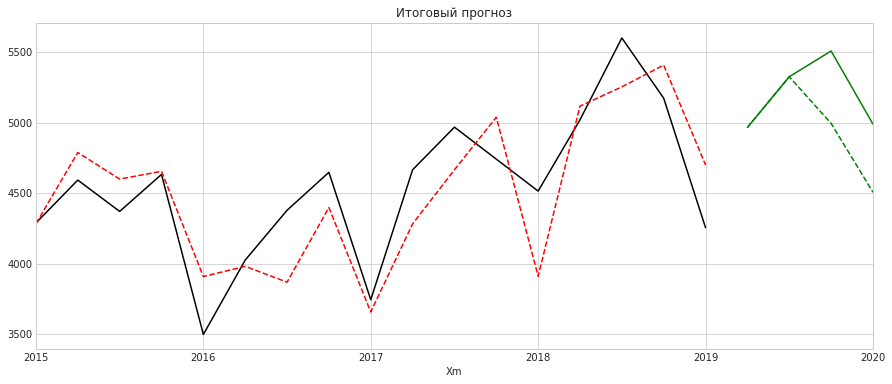

In [91]:
ax = df.Y.plot(figsize=(15,6), color='black', title="Итоговый прогноз" )
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(4).plot(ax=ax, style='--', color='green')
forecast.plot(ax=ax, color='green')
plt.show()

Сплошная зеленая линия – экспертная корректировка математического прогноза. Прерывистая зеленая линия – математический прогноз.

# Выводы по итогам математического прогнозирования

Все модели, за исключением модели SARIMA, по кварталам оказались адекватными и пригодными для прогнозирования. Самый точный прогноз тестовых данных удалось сделать поквартально методом Хольта-Винтерса с аддитивным трендом и мультипликативной сезонностью. 

Большие перспективы для помесячного прогнозирования при дальнейшей проработке может показать модель множественной регрессии по месяцам. 

**Методические указания**: *итоговый прогноз (корректировка экспертом математической модели) можно представить в Excel.*

# Модель Монте-Карло

**Описание модели**

Надо сбалансировать фронт подачи вагонов и количество грузоподъемных механизмов для того, чтобы в 90% случаев обрабатывать прибывшие контейнера в одну подачу.

Существующий фронт подачи вагонов на условном контейнерном терминале – 30 усл. ваг. Для моделирования использовались данные тактического прогноза переработки контейнеров. При данном фронте в среднем вагоны обрабатываются в 27% случаев в одну подачу, в 60% случаев – в две подачи и в 13% случаев – в три подачи. Необходимость производить маневровую работу существенно увеличивает время обработки контейнеров, тем самым увеличивая срок доставки груза.

Моделирование будем производить исходя из самого загруженного месяца – мая 2018 года.

**Данные**

Из файла Excel загрузим статистику по поступлению контейнеров. Также мы знаем, что один грузоподъемный механизм обрабатывает 30 условных вагонов (60 контейнеров):
- 5 часов – 10 раз,
- 6 часов – 15 раз,
- 7 часов – 5 раз.

Норматив обработки – 11 часов на один грузоподъемный механизм. Из-за отсутствия точных замеров времени на обработку одной подачи предположим, что это треугольное распределение с наиболее ожидаемым значением 5,7 часа.

Количество итераций для экспериментов – 1000, зададим в переменной size.

(array([ 43.,  90., 150., 189., 151., 132., 123.,  59.,  46.,  17.]),
 array([5.03736571, 5.23156496, 5.42576421, 5.61996346, 5.8141627 ,
        6.00836195, 6.2025612 , 6.39676045, 6.5909597 , 6.78515894,
        6.97935819]),
 <BarContainer object of 10 artists>)

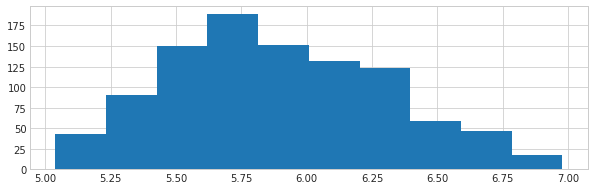

In [92]:
size = 1000

tpod = np.random.triangular(left = 5, mode = 5.7, right = 7, size = size)
plt.hist(tpod)

Загрузим статистику поступления вагонов за месяц с листа "МК" и изучим параметры распределения.

In [93]:
df=pd.read_excel("sample_dataset.xlsx", sheet_name='MK')
df.head()

,май 2018,Контейнера,Вагоны
0,1,55,28
1,2,64,32
2,3,82,42
3,4,93,47
4,5,48,24


In [94]:
df.describe()

,май 2018,Контейнера,Вагоны
count,30.000000,30.000000,30.000000
mean,15.500000,75.600000,37.966667
std,8.803408,28.673669,14.530547
min,1.000000,35.000000,18.000000
25%,8.250000,50.500000,25.750000
50%,15.500000,78.500000,39.000000
75%,22.750000,93.000000,47.000000
max,30.000000,125.000000,63.000000


<AxesSubplot:>

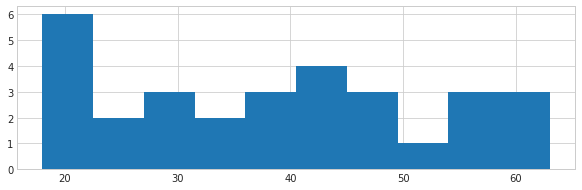

In [95]:
df['Вагоны'].hist()

Поступление вагонов похоже на равномерное распределение. Его и будем использовать для моделирования с границами минимум 18, максимум 63 вагона.

(array([127.,  93., 115.,  80.,  87.,  96.,  88., 112.,  88., 114.]),
 array([18. , 22.4, 26.8, 31.2, 35.6, 40. , 44.4, 48.8, 53.2, 57.6, 62. ]),
 <BarContainer object of 10 artists>)

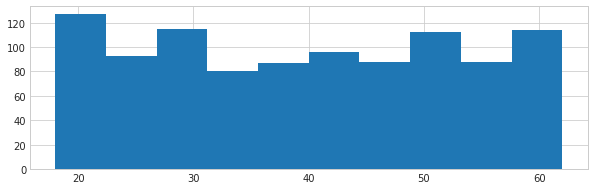

In [96]:
vagon = np.random.uniform(low = 18, high = 63, size = size).astype(int)
plt.hist(vagon)

Построим модель для одного механизма. Из бюджета времени одного грузоподъемного механизма будем вычитать количество подач, которое рассчитаем как бюджет времени одного механизма минус количество подач умножить на смоделированное время по их переработке. Если время превышает бюджет, отрицательное значение, значит мы не смогли в течение дня переработать все поступления. 

**Методические указания**: для массивов numpy командой *.astype(int)* мы приводим значения к целым числам. Вернее, данная команда отбрасывает дробную часть. И если у нас получилось значение 0.89, то результат преобразования будет 0. По этой причине добавляем 1.

Если возникнут затруднения с моделированием, обращайтесь к преподавателю курса.

Случаи превышения времени: 595


(array([ 10.,  32.,  26.,   8.,  85., 359., 196.,   0.,  15., 269.]),
 array([-9.53945557, -7.9913544 , -6.44325323, -4.89515206, -3.34705088,
        -1.79894971, -0.25084854,  1.29725263,  2.8453538 ,  4.39345497,
         5.94155614]),
 <BarContainer object of 10 artists>)

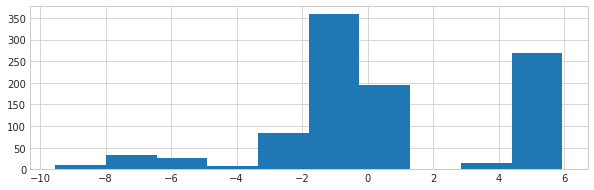

In [97]:
budget_one=11
front=30
time_for_work=budget_one-((vagon/front).astype(int)+1)*tpod
print('Случаи превышения времени:', (time_for_work<0).sum())
plt.hist(time_for_work)

Более чем в 662 случаях из 1000 один грузоподъемный механизм не укладывается в бюджет времени при работе в самый напряженный месяц. Причем значительное количество отклонений не столь велико – не более двух часов. Стоит поискать возможности для оптимизации работы, чтобы справляться одним механизмом. 

Изучим результаты моделирования для двух механизмов.

Случаи превышения времени: 0


(array([ 10.,  32.,  26.,   8.,  85., 359., 196.,   0.,  15., 269.]),
 array([ 1.46054443,  3.0086456 ,  4.55674677,  6.10484794,  7.65294912,
         9.20105029, 10.74915146, 12.29725263, 13.8453538 , 15.39345497,
        16.94155614]),
 <BarContainer object of 10 artists>)

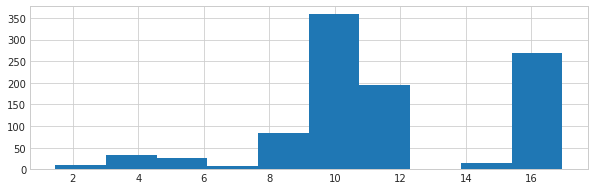

In [98]:
budget_one=11*2
front=30
time_for_work=budget_one-((vagon/front).astype(int)+1)*tpod
print('Случаи превышения времени:', (time_for_work<0).sum())
plt.hist(time_for_work)

Два грузоподъемных механизма с большим запасом справляются с работой и значительную часть времени простаивают.

Попробуем подобрать значение потока вагонов, которое могут обсужить два механизма при том же распределении времени обслуживания одной подачи. Будем генерировать равномерную подачу вагонов.

Моделирование производилось в диапазоне от 50 до 100 вагонов в сутки.

Случаи превышения времени: 0


(array([ 17.,  46.,  59., 123., 132., 151., 189., 150.,  90.,  43.]),
 array([1.06192543, 1.64452317, 2.22712091, 2.80971866, 3.3923164 ,
        3.97491414, 4.55751189, 5.14010963, 5.72270737, 6.30530512,
        6.88790286]),
 <BarContainer object of 10 artists>)

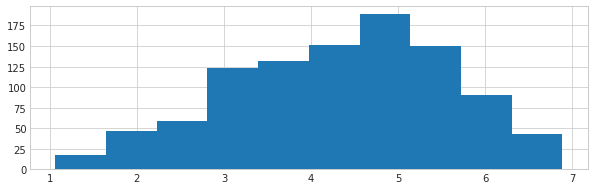

In [99]:
budget_one=11*2
front=30
vagon2=np.array([89 for x in range(0,1000)])
time_for_work=budget_one-((vagon2/front).astype(int)+1)*tpod
print('Случаи превышения времени:', (time_for_work<0).sum())
plt.hist(time_for_work)

Случаи превышения времени: 817


(array([ 17.,  46.,  59., 123., 132., 151., 189., 150.,  90.,  43.]),
 array([-5.91743277, -5.14063578, -4.36383878, -3.58704179, -2.8102448 ,
        -2.03344781, -1.25665082, -0.47985383,  0.29694316,  1.07374015,
         1.85053715]),
 <BarContainer object of 10 artists>)

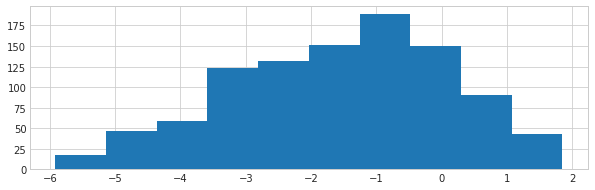

In [100]:
budget_one=11*2
front=30
vagon2=np.array([90 for x in range(0,1000)])
time_for_work=budget_one-((vagon2/front).astype(int)+1)*tpod
print('Случаи превышения времени:', (time_for_work<0).sum())
plt.hist(time_for_work)

Мы видим, что два грузоподъемных механизма могут гарантированно и с запасом обслуживать до 90 вагонов, что соответствует трем подачам в сутки. Но в данном случае имеет смысл увеличить фронт подачи вагонов до полезной длины в 45 условных вагонов.